<a href="https://colab.research.google.com/github/Sathvik-Srivathsan/Neural-Networks/blob/main/Neural_Networks_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from statistics import mean

<Axes: xlabel='tmax', ylabel='tmax_tomorrow'>

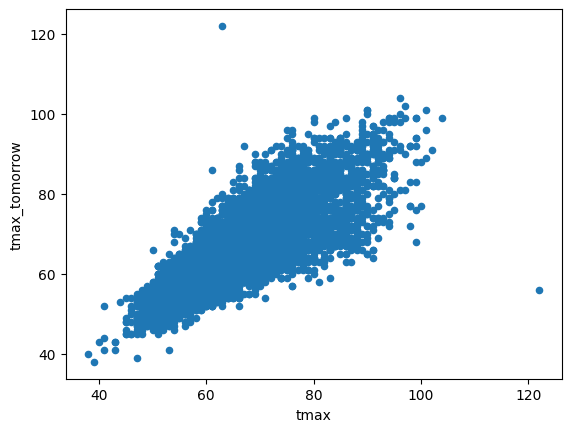

In [15]:
data = pd.read_csv("/content/clean_weather.csv", index_col=0)
data = data.ffill()
data.plot.scatter("tmax", "tmax_tomorrow")

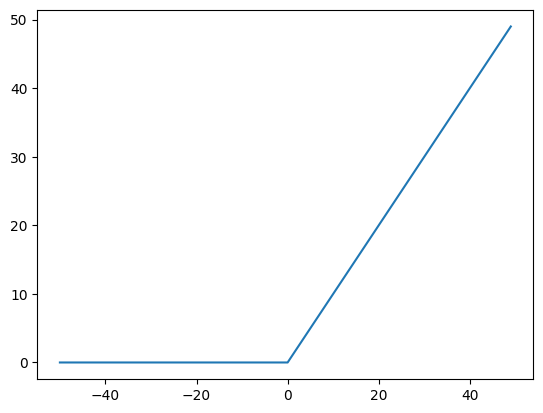

In [16]:
#@title ReLU Function
temps = np.arange(-50,50)

plt.plot(temps, np.maximum(0, temps))

In [17]:
#predictors are besically the input and the target is the output and think of each of these things as labels; DONT if it makes it harder to understand
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data so relu works better
# All temperature values in the original dataset are over 0, so relu won't do much for several epochs
# Scaling will make some of the input data negative
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

#training set is to train the algorithm, validation set is to tune the hyperparameters like learning rate, bach size, etc and test is for final evaluation
split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
def init_layers(inputs):
    layers = []
    #Loop thru inputs to initialize weights and biases for each layer
    for i in range(1, len(inputs)):
        layers.append([
            #np.random.rand generates random values from 0 to 1 of shape <arg 1> x <arg 2>. This is to make it fall b/w -0.1 and 0.1
            #shape of matrix = <no of cols in prev layer> x <no of cols in this layer>
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1,inputs[i]))
        ])
    return layers

# This will initialize weights and biases for a 3-layer neural network with 10 units in the first layer, 10 in the second, and 1 in the final
# The first number (3) is our number of input features
layer_conf = [3,10,10,1]

In [19]:
def forward(batch, layers):
    hidden = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        # Store the forward pass hidden values for use in backprop
        hidden.append(batch.copy())
    return batch, hidden

In [20]:
mse = lambda actual, predicted: (actual - predicted) ** 2

mse_grad = lambda actual, predicted: predicted - actual

In [21]:
def backward(layers, hidden, grad, lr):
    for i in range(len(layers)-1, -1, -1):
        if i != len(layers) - 1:
            grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

        w_grad = hidden[i].T @ grad
        b_grad = np.mean(grad, axis=0)

        layers[i][0] -= w_grad * lr
        layers[i][1] -= b_grad * lr

        grad = grad @ layers[i][0].T
    return layers

In [22]:
lr = 1e-6
epochs=10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = []

    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]
        pred, hidden = forward(x_batch, layers)

        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss ** 2))

        layers = backward(layers, hidden, loss, lr)


    valid_preds, _ = forward(valid_x, layers)

    print(f"Epoch: {epoch} Train MSE: {mean(epoch_loss)} Valid MSE: {np.mean(mse(valid_preds,valid_y))}")

Epoch: 0 Train MSE: 3345.8081412940423 Valid MSE: 1797.3640496527835
Epoch: 1 Train MSE: 375.0015599868665 Valid MSE: 27.27465035189849
Epoch: 2 Train MSE: 23.62362693587826 Valid MSE: 21.48165884740003
Epoch: 3 Train MSE: 22.5249799337948 Valid MSE: 20.901943455811058
Epoch: 4 Train MSE: 22.218233880129556 Valid MSE: 20.78974526155598
Epoch: 5 Train MSE: 22.140184546719937 Valid MSE: 20.773841658390555
Epoch: 6 Train MSE: 22.118591387681764 Valid MSE: 20.775288408696635
Epoch: 7 Train MSE: 22.111190352826174 Valid MSE: 20.778516758926855
Epoch: 8 Train MSE: 22.107613591844398 Valid MSE: 20.781034302637963
Epoch: 9 Train MSE: 22.105076486016536 Valid MSE: 20.782467411554247


In [23]:
pred, hidden = forward(test_x, layers)
np.mean(mse(test_y, pred))

22.10272120895696